In [ ]:
import os
import sys
import torchvision.transforms as tvt
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pycocotools.coco import COCO
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
from skimage import io
import requests
import cv2
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
import warnings
from skimage.color import gray2rgb
import time
import progressbar
from io import StringIO,BytesIO
import torch.optim as optim
import json

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip

--2023-03-22 23:31:50--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.135.35, 52.216.226.48, 52.217.79.180, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.135.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  32.9MB/s    in 8.5s    

2023-03-22 23:31:59 (28.4 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [ ]:
class CocoDownloader:
    def __init__(self, root_path, coco_json_path,class_list,mode):
        self.root_path = root_path
        self.coco_json_path = coco_json_path
        self.class_list = class_list
        self.coco = COCO(self.coco_json_path)
        self.mode = mode

        # make coco root dir if doesnt exist
        if not os.path.exists(os.path.split(os.path.split(self.root_path)[0])[0] + '/'):
            os.makedirs(os.path.split(os.path.split(self.root_path)[0])[0] + '/')
        # make train/val dir if doesnt exist
        if not os.path.exists(os.path.split(self.root_path)[0] + '/'):
            os.makedirs(os.path.split(self.root_path)[0] + '/')
        # make class dirs if doesnt exist
        for c in self.class_list:
            if not os.path.exists(self.root_path + c):
                os.makedirs(self.root_path + c)
      

    def download_imgs(self):
      img_ID = []
      resize_image = (256,256)
      catIds = self.coco.getCatIds(catNms=self.class_list)
      resize_image = (256,256)
      for catId in catIds:
        img_ID.extend(self.coco.getImgIds(catIds=catId ))
      self.image_details = []
      for img_index in range(len(img_ID)):
        img = self.coco.loadImgs(img_ID[img_index])[0]
        ann_ids = self.coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        tmp=[]
        h = img['height']
        w = img['width']
        w_divisor = w / 256
        h_divisor = h / 256
        nottake = 0
        for ann in anns:
          if ann['area'] < 4096:
            nottake=1 
            break
          bbox = ann['bbox']
          bbox_rescaled = [bbox[0] / w_divisor , bbox[1] / h_divisor ,  bbox[2] / w_divisor, bbox[3]/h_divisor]
          tmp.append({'b_box' : bbox_rescaled ,'category_id': ann['category_id']})
        
        if nottake == 1:continue
        image_annotation = {"file_name": img['file_name'] , "main_category" : ann['category_id'] , "img_id" : img['id'] , 'ann_id' : ann_ids , 'objects' : tmp ,
                                     "img_h" : img['height'],"img_w":img['width']}
        self.image_details.append(image_annotation)
        img_data = requests.get(img['coco_url']).content
        if(ann['category_id'] == 6):
          c = 'bus'
        if(ann['category_id'] == 59):
          c = 'pizza'
        if(ann['category_id'] == 17):
          c = 'cat'
        
        
        img_filename_path = os.path.join(self.root_path + c ,img['file_name'])
        with open(img_filename_path, 'wb') as im_w:
          im_w.write(img_data)
        im = Image.open(img_filename_path)
        if im.mode=='L':
            im = np.asarray(im)
            im = gray2rgb(im)
            im = Image.fromarray(im)
        im_resized = im.resize(resize_image, Image.BOX)
        im_resized.save(img_filename_path)
      with open('data_'+self.mode+'.json', 'w') as file:
            json.dump(self.image_details, file)
      return self.image_details


In [ ]:
rm -rf HW6data/

In [ ]:
class_list = ['bus', 'cat', 'pizza']
coco_json_path1 = 'annotations/instances_train2014.json'
root_path1 = './HW6data/train/'
dl_coco1 = CocoDownloader(root_path1 , coco_json_path1, class_list,"train")
image_details = dl_coco1.download_imgs()

loading annotations into memory...
Done (t=12.09s)
creating index...
index created!


In [ ]:
coco_json_path2 = 'annotations/instances_val2014.json'
root_path2 = './HW6data/val/'
dl_coco2 = CocoDownloader(root_path2 , coco_json_path2, class_list,"val")
image_details_val = dl_coco2.download_imgs()

loading annotations into memory...
Done (t=4.60s)
creating index...
index created!


In [ ]:
image_details = json.load(open('data_train.json'))

{'file_name': 'COCO_train2014_000000049338.jpg', 'main_category': 6, 'img_id': 49338, 'ann_id': [164277], 'objects': [{'b_box': [0.648, 0.0, 123.63199999999999, 499.9144921875], 'category_id': 6}], 'img_h': 361, 'img_w': 640}


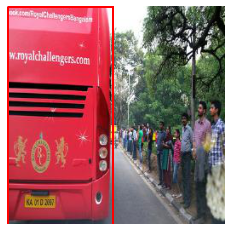

In [ ]:
im = {}
im = image_details[60]
print(im)
    # load image and annotations
img = Image.open("HW6data/train/bus/" + im['file_name'])
anns = im['ann_id']
    
    # plot image and bounding boxes
plt.imshow(img)
plt.axis('off')
ob = im['objects']
for i in ob :
  bbox = i['b_box']
  plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='r', linewidth=2))
  plt.show()

Finding a cell Index which corresponds to the cell Index 

In [ ]:
def cellIndex(c,cells,yolo_interval):
  for i in range(cells):
    if c>=(yolo_interval*i) and c<=(yolo_interval*(i+1)):
      return i

Taken from the internet

In [ ]:
def calculate_iou(boxes1, boxes2):
        """
        Parameters:
            boxes1 (tensor): width and height of the first bounding boxes
            boxes2 (tensor): width and height of the second bounding boxes
        Returns:
            tensor: Intersection over union of the corresponding boxes
        """
        #print(f" box1 = {boxes1} box2 = {boxes2}")
        intersection = min(boxes1[0],boxes2[0]) * min(boxes1[1],boxes2[1])
        union = boxes1[0]*boxes1[1] + boxes2[0]*boxes2[1] - intersection
        #print(f"intersection = {intersection} Union = {union}")
        return intersection / union

In [ ]:
anchorBoxes = []
yolo_interval = 32 
AR = []
for i in range(1,5):
    for j in range(1,5):
        if i/j not in AR:
            AR.append(round(i/j,3))
            anchorBoxes.append((yolo_interval*i , yolo_interval*j))

In [ ]:
print(len(anchorBoxes))

11


The idea to sent yolo_tensor was discussed during the office hours and after having discussion with classmates. After discussing in office hours the logic of yolo_tensor was implemented

In [ ]:
class myDataset(torch.utils.data.Dataset):
  def __init__(self,root,imageInfo,transform, anchorBoxes ):
    self.root = root
    self.data = []
    self.imgInfo = imageInfo
    self.transform = transform
    self.anchorBoxes = anchorBoxes
  
  def __len__(self):
    return len(self.imgInfo)

  def __getitem__(self , idx):
    category = self.imgInfo[idx]['main_category']
    if category == 59:
      c = "pizza/"
    if category == 6:
      c = "bus/"
    if category == 17:
      c = "cat/"
    file_path = os.path.join(self.root , c  , self.imgInfo[idx]['file_name'])
    image = Image.open(file_path)
    im_tnsr = self.transform(image)
    im = {}
    im = self.imgInfo[idx]
    grid = 256//32

    best_bbox_index = 0
     # print(len(im['objects']))
    yolo_tensor = torch.zeros(grid, grid, len(self.anchorBoxes) , (3+5))
    for index in im['objects']:
        bbox_gt = index['b_box']
        #print(bbox_gt)
        object_category = index['category_id']
        #print(object_category)


        # Convert ground truth bounding box to (x_center, y_center, width, height)
        x = bbox_gt[0] +  bbox_gt[2] * 0.5
        y = bbox_gt[1] +  bbox_gt[3] * 0.5
        
        # Calculate cell indices that contain the center of the bounding box
        cell_x = cellIndex(x,grid,32)
        cell_y = cellIndex(y,grid,32)
        
        x, y, w, h = bbox_gt[0], bbox_gt[1], bbox_gt[2], bbox_gt[3]
        all_ious = [calculate_iou(anchor_box,(w,h)) for anchor_box in self.anchorBoxes]
        
        best_anchor_index = all_ious.index(max(all_ious))
        dx = ((32*cell_x + 32/2) - x)/32
        dy = ((32*cell_y + 32/2) - y)/32

        anchor_w = w / self.anchorBoxes[best_anchor_index][0]
        anchor_h = h / self.anchorBoxes[best_anchor_index][1]
        
        if object_category == 6:
          class_label = [1 , 0 , 0]
  
        if object_category == 17:
          class_label =  [0 , 1 , 0]
        
        if object_category == 59:
          class_label = [0 , 0 , 1]

        
        yolo_vector = [1 , dx , dy , anchor_w , anchor_h]
        yolo_vector.extend(class_label)

        yolo_tensor[cell_x][cell_y][best_anchor_index] = torch.tensor(yolo_vector)
    
    return im_tnsr , yolo_tensor


transform = tvt.Compose([tvt.ToTensor()])
dataloader_train = myDataset("HW6data/train", image_details, transform , anchorBoxes )
loader = torch.utils.data.DataLoader(dataloader_train, batch_size=16,shuffle=True)
print(len(loader.dataset))


6192


In [ ]:
transform = tvt.Compose([tvt.ToTensor()])
dataloader_train = myDataset("HW6data/val", image_details_val, transform , anchorBoxes )
loader_val = torch.utils.data.DataLoader(dataloader_train, batch_size=1,shuffle=True)
print(len(loader_val.dataset))

3177


In [ ]:
for image, yolo_tensor in loader:
  #finding the indexes where object are present. We can get rid of batch here because the batch size is 0

  ObjectPresent = np.where(yolo_tensor[0][:,:,:,0] == 1)
  ground_truth_value = yolo_tensor[0][ ObjectPresent[0] , ObjectPresent[1] , ObjectPresent[2]]
  bbox = ground_truth_value[0][1:5]

  category = ground_truth_value[0][5:].tolist()
  print(category)

  if category == [1.0 , 0.0, 0.0]:
    print("bus")
    label = '6'
  
  if category == [0.0 , 1.0 , 0.0]:
    print("cat")
    label = '17'

  if category == [0.0, 0.0, 1.0]:
    print("pizza")
    label = '59'  

  #looping throught the inages to find the center of bboxes 
  details = []

  for i in range(len(ObjectPresent[0])):
    cell_i = (ObjectPresent[0][i],ObjectPresent[1][i])
    #print(cell_idx)

    anchor_box_idx = ObjectPresent[2][i]
    #print(anchor_box_idx)

    cell_x = (cell_i[0])*32 + 32/2
    cell_y = (cell_i[1])*32 + 32/2

    obj_x = cell_x - bbox[0]*32
    obj_y = cell_y - bbox[1]*32

    w , h = anchorBoxes[anchor_box_idx][0]*bbox[2] , anchorBoxes[anchor_box_idx][1]*bbox[3]
    bbox = [obj_x , obj_y  , w, h]


    
    details.append({'bbox' : bbox , 'category_id' : label})
    #print(details)
  
  images = np.array(image[0].permute(1, 2, 0)).copy()
  sample_image = make_bb(images , details, "true")
  plt.imshow((images*255).astype('uint8'))
  plt.show()

Inspiration of the network is taken by https://www.youtube.com/watch?v=Grir6TZbc1M&t=1777s&ab_channel=AladdinPersson.

In [ ]:
class ResidualBlock(torch.nn.Module):
    """ Helper Class"""

    def __init__(self, channels):
        
        super(ResidualBlock, self).__init__()
        
        self.block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=(2, 2),
                                padding=1),
                torch.nn.BatchNorm2d(channels[1]),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),   
                torch.nn.BatchNorm2d(channels[2])
        )

        self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(2, 2),
                                padding=0),
                torch.nn.BatchNorm2d(channels[2])
        )
            
    def forward(self, x):
        shortcut = x
        block = self.block(x)
        shortcut = self.shortcut(x)    
        x = torch.nn.functional.relu(block+shortcut)
        return x

In [ ]:
class HW6Net(nn.Module):
  def __init__ (self , input_nc, classes , anchor_box):
    super(HW6Net, self).__init__()

    self.rc = nn.ReflectionPad2d(2)
    #first convolution block
    self.layer1 = nn.Sequential(nn.Conv2d(input_nc , 16 , 3),
                                nn.BatchNorm2d(16))

    #downsampling

    self.downsampling = nn.Sequential(nn.Conv2d(16, 32, 3 , 2),
                                      nn.Conv2d(32, 16,  3 , 2 , 1),
                                      nn.BatchNorm2d(16))

    #residual block 1
    self.residual = nn.Sequential(ResidualBlock(channels=[16, 16 , 32]),
                                  ResidualBlock(channels=[32 , 64, 128]))

    #convolution block
    self.conv_2  = nn.Sequential(nn.Conv2d(128,64 , 4 ),
                                 nn.Conv2d(64 , 32 , 4 ),
                                 nn.BatchNorm2d(32),
                                 nn.Conv2d(32,11*(8), 3 ))

    #linear layer
    #self.fc = nn.Sequential(nn.Linear(12544, 1024),
     #                       nn.Linear(1024,512),
      #                      nn.Linear(512, 3),
       #                     )


  def forward(self , input):
      
      input1 = input.clone()
      #images
      x = self.rc(input)
      x1 = self.layer1(x)
      x2 = self.downsampling(x1)
      x3 = self.residual(x2)
      x4 = self.conv_2(x3)
      #print(x4.shape)

      #reshape
      #x4 = x4.reshape(-1,12544)
      #fully connected layers
      #x5 = self.fc(x4)

      return x4


In [ ]:
model = HW6Net(3,3,11).cuda()
print(model)

HW6Net(
  (rc): ReflectionPad2d((2, 2, 2, 2))
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downsampling): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1),

Shape of the yolo_tensor (N, S, S, B, 5 + C)

Help taken from chat gpt and https://stackoverflow.com/questions/58136592/for-a-given-condition-get-indices-of-values-in-2d-tensor-a-use-those-to-index for setting the indicees. The training part of the code is inspired by the https://www.youtube.com/watch?v=Grir6TZbc1M&t=1777s&ab_channel=AladdinPersson.

In [ ]:
model = HW6Net(3,3,16).cuda()

criterion1 = nn.BCELoss()                    # For the first element of the 8 element yolo vector              ## (3)
criterion2 = nn.MSELoss()                    # For the regression elements (indexed 2,3,4,5) of yolo vector   ## (4)
criterion3 = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas =( 0.9 , 0.99 ))

epochs=10
bceLoss = []
mseLoss = []
ceLoss = []

for epoch in range( epochs ):
  runningLoss = 0.0
  bce = 0.0
  mse = 0.0
  ce = 0.0
  completeLoss = []
  for i , data in enumerate(loader):
    image, yoloDataloader = data
    image = image.cuda()
    yoloDataloader = yoloDataloader.cuda()
    optimizer.zero_grad()
    
    pred = model(image)
    pred = pred.reshape(16 , 8 , 8 , 11 , 8)
            
    loss = torch.tensor(0.0, requires_grad=True).float().cuda() 
    objectPresent = torch.where(yoloDataloader.cpu()[:,:,:,:,0] == 1)
    #print(objectPresent)
    noObject = torch.where(yoloDataloader.cpu()[:,:,:,:,0] == 0)
            
    #predictions when object is present in the grid there
    predictions = pred[objectPresent[0] , objectPresent[1] , objectPresent[2] , objectPresent[3]]
    #print(predictions.shape)
    groundtruth = yoloDataloader[objectPresent[0] , objectPresent[1] , objectPresent[2] , objectPresent[3]]

    
    #Loss 1 which is Binary Cross Entropy between the presence of the object in the predictions and grounf truth 
    loss1 = criterion1(nn.Sigmoid()(predictions[:,0]) , groundtruth[:,0])
    loss += loss1
    bce += loss1.item()
            
    #Loss 2 which is MSE loss between the bounding boxes
    loss2 = criterion2(predictions[:,1:5] , groundtruth[:,1:5])
    loss += loss2
    mse += loss2.item()
            
    #loss 3 which is cross entropy loss for multiclassification 
    loss3 = criterion3(predictions[:,5:] , groundtruth[:,5:])
    loss += loss3
    ce+=loss3.item()

    #calculating the bce loss when the object is not present so that we can have that loss incorporated as well in training
    predictions = pred[objectPresent[0] , objectPresent[1] , objectPresent[2] , objectPresent[3]]
    groundtruth = yoloDataloader[objectPresent[0] , objectPresent[1] , objectPresent[2] , objectPresent[3]]

    loss1 = criterion1(nn.Sigmoid()(predictions[:,0]) , groundtruth[:,0])
    loss += loss1
    bce += loss1.item()
    
    loss.backward()
    optimizer.step()

      
    runningLoss+= loss.item()
    
    if(i+1)% 100 == 0:
      print("here")
      print(f"[ epoch : {epoch + 1}, batch : {i + 1}] loss : {round(runningLoss/100,3)}")
      completeLoss.append(runningLoss/100)
      bceLoss.append(bce/100)
      mseLoss.append(mse/100)
      ceLoss.append(ce/100)
                
      runningLoss = 0.0
      bce = 0.0
      reg = 0.0
      ce = 0.0

    del image
    del yoloDataloader
    del pred
    #gc.collect()


here
[ epoch : 1, batch : 100] loss : 6.307
here
[ epoch : 1, batch : 200] loss : 5.27
here
[ epoch : 1, batch : 300] loss : 2.665
here
[ epoch : 2, batch : 100] loss : 1.775
here
[ epoch : 2, batch : 200] loss : 1.806
here
[ epoch : 2, batch : 300] loss : 1.784
here
[ epoch : 3, batch : 100] loss : 1.755
here
[ epoch : 3, batch : 200] loss : 1.744
here
[ epoch : 3, batch : 300] loss : 1.739
here
[ epoch : 4, batch : 100] loss : 1.72
here
[ epoch : 4, batch : 200] loss : 1.723
here
[ epoch : 4, batch : 300] loss : 1.72
here
[ epoch : 5, batch : 100] loss : 1.672
here
[ epoch : 5, batch : 200] loss : 1.682
here
[ epoch : 5, batch : 300] loss : 1.701
here
[ epoch : 6, batch : 100] loss : 1.603
here
[ epoch : 6, batch : 200] loss : 1.614
here
[ epoch : 6, batch : 300] loss : 1.623
here
[ epoch : 7, batch : 100] loss : 1.483
here
[ epoch : 7, batch : 200] loss : 1.49
here
[ epoch : 7, batch : 300] loss : 1.535
here
[ epoch : 8, batch : 100] loss : 1.328
here
[ epoch : 8, batch : 200] loss 

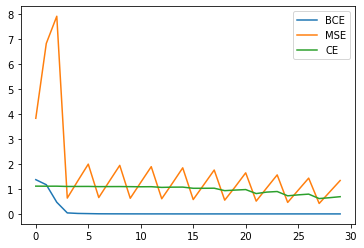

In [ ]:
plt.plot(bceLoss , label = "BCE")
plt.plot(mseLoss , label = "MSE")
plt.plot(ceLoss , label = "CE")
plt.legend()
plt.show()

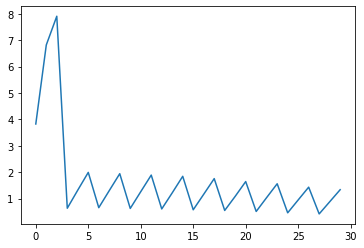

In [ ]:
plt.plot(mseLoss , label = "MSE")

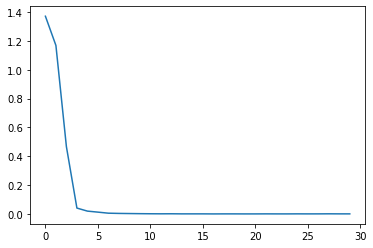

In [ ]:
plt.plot(bceLoss , label = "MSE")

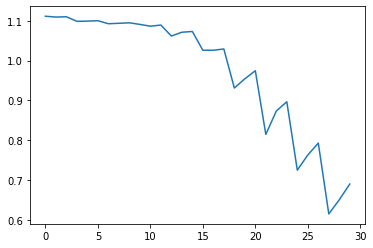

In [ ]:
plt.plot(ceLoss , label = "MSE")

The code was taken from the previous implementations to implement in the bounding box. It is inspored from the code block given in previous homework template

In [ ]:
def make_bb(image , obj , flag):
    if flag =='true':
        color = (0,1,0)
    else:
        color = (1,1,0)
    for i in obj:
        [x , y , w , h] = i['bbox']
        image = cv2.rectangle ( image , (int( x ) , int( y ) ) , (int( x + w ) , int ( y + h ) ) , color , 2 )
        image = cv2.putText ( image , flag + "_" + i['category_id'], (int( x ) , int( y - 10 ) ) , cv2.FONT_HERSHEY_SIMPLEX , 1,color , 2 )
    return image

In [ ]:
#using numpy here so that we can print images and the bounding boxes
for image, yolo_tensor in loader_val:
  #finding the indexes where object are present. We can get rid of batch here because the batch size is 0

  ObjectPresent = np.where(yolo_tensor[0][:,:,:,0] == 1)
  ground_truth_value = yolo_tensor[0][ ObjectPresent[0] , ObjectPresent[1] , ObjectPresent[2]]
  bbox = ground_truth_value[0][1:5]

  category = ground_truth_value[0][5:].tolist()
  print(category)

  if category == [1.0 , 0.0, 0.0]:
    print("bus")
    label = '6'
  
  if category == [0.0 , 1.0 , 0.0]:
    print("cat")
    label = '17'

  if category == [0.0, 0.0, 1.0]:
    print("pizza")
    label = '59'  

  #looping throught the inages to find the center of bboxes 
  details = []

  for i in range(len(ObjectPresent[0])):
    cell_i = (ObjectPresent[0][i],ObjectPresent[1][i])
    best_anchor = ObjectPresent[2][i]

    #finding bboxes by removing offsetts
    cell_x = (cell_i[0])*32 + 32/2
    cell_y = (cell_i[1])*32 + 32/2

    obj_x = cell_x - bbox[0]*32
    obj_y = cell_y - bbox[1]*32

    w , h = anchorBoxes[best_anchor][0]*bbox[2] , anchorBoxes[best_anchor][1]*bbox[3]
    bbox = [obj_x , obj_y  , w, h]

    details.append({'bbox' : bbox , 'category_id' : label})
    print(details)
  
  images = np.array(image[0].permute(1, 2, 0)).copy()
  sample_image = make_bb(images , details, "true")

  image = image.cuda()
  preds = model(image)
  preds = preds[0].reshape(8,8,11,8)

  objectLength = len(details)
  
  #The tensor is converted to numpy array becuase we want to calculate the maximum 
  #value of the object presented and the length of those value should be equal 
  #to the numbe of objects present
  pred_numpy = preds.cpu().detach().numpy()
  maximum = np.sort(pred_numpy[:,:,:,0].flatten())[-objectLength:]

  objects_pred = []
  label = '0'

  #just flip the values for decreasing to increasing
  for val in np.flip(maximum):
    predMaxi = np.where(pred_numpy[:,:,:,0] == val)
    
    cell = (predMaxi[0][0] , predMaxi[1][0])
    
    best_anchor = predMaxi[2][0]
    
    output = preds[0][predMaxi[0],predMaxi[1],predMaxi[2]]
    bbox = output[0][1:5]

    yolo_vector_cnn = pred_numpy[predMaxi[0] , predMaxi[1] , predMaxi[2]]
    categoryIndexes = np.argmax(yolo_vector_cnn[5:][0])
    
    findCategory = np.argmax((pred_numpy[predMaxi[0],predMaxi[1],predMaxi[2],5:][0]))
    
    # matching category
    if findCategory == 0:
      c = '59'
    if findCategory == 1:
      c = '6'
    if findCategory == 2:
      c = '17'
    
    print(cell)
    cell_x = (cell_i[0])*32 + 32/2
    cell_y = (cell_i[1])*32 + 32/2

    obj_x = cell_x - bbox[0]*32
    obj_y = cell_y - bbox[1]*32

    w , h = anchorBoxes[best_anchor][0]*bbox[2] , anchorBoxes[best_anchor][1]*bbox[3]
    bbox = [obj_x , obj_y , w, h]



    objects_pred.append({'bbox':bbox , 'category_id':c})

  print("here")
  
  images = make_bb(images,objects_pred,"f")
  plt.imshow((images*255).astype('uint8'))
  plt.show()





